In [1]:
!git clone https://gitlab1.ptb.de/hoffma31/bayesiandeepensembles.git

Cloning into 'bayesiandeepensembles'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), 1.02 MiB | 1.11 MiB/s, done.


In [2]:
%cd bayesiandeepensembles

/kaggle/working/bayesiandeepensembles


In [3]:
import bdeepens as f
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

torch.backends.cudnn.benchmark = False
def set_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [4]:
# constant values
p_y = 1 # output dimension
n_test = 500 # amount of test data (includes out-of-distribution data)
n_val = 500 # amount of validation data
sigma_x = 0 # noise in input space (standard deviation of normal distribution)
do_normalize = True # normalize all output data (based on training data)
do_plot = True # do some additional plots
do_homosc = False # heteroscedastic or homoscedastic aleatoric uncertainty predictions
markersz = 4 # markersize for plots
mbs = 64 # mini batch size
epochs = 60 # number of training epochs
anz_n = [128, 64, 32] # number of neurons in the hidden layers (concerning the network architecture)
gradDecay = 0.9 # parameter for the adam optimizer
sqGradDecay = 0.999 # parameter for the adam optimizer
eps = 1e-5 # parameter for the adam optimizer
lrDF = 0.1 # learning rate drop factor
epochs_last = 5 # drop the learning rate in each of the last epochs

# functions
func1 = lambda x: 0.5 * ((4.5 * x)**4 - 16 * (4.5 * x)**2 + 5 * (4.5 * x)).sum(1)
func2 = lambda x: ((1.5 * x - 1)**2 * (1.3 * x + 1)**2).sum(1)
func3 = lambda x: ((1.5 * x)**3).sum(1)
func4 = lambda x: (x * np.sin(10 * x)).sum(1)

## Algorithm 1:
Extend the approximation for the posterior $\pi (\theta|D)$ from $q(\theta) := \frac{1}{L} \sum_{l=1}^L \delta(\theta - \widehat{\theta}^{(l)})$ to $q(\theta) := \frac{1}{L} \sum_{l=1}^L N(\theta;\widehat{\theta}^{(l)}, \gamma_l I)$

 1. initialize and independently train networks $\eta_{\widehat{\theta}^{(l)}}$, $l=1,\ldots,L,$ according to the deep ensembles approach
 2. analytically compute $\gamma_l$, $l=1,\ldots,L,$ that maximize the ELBO

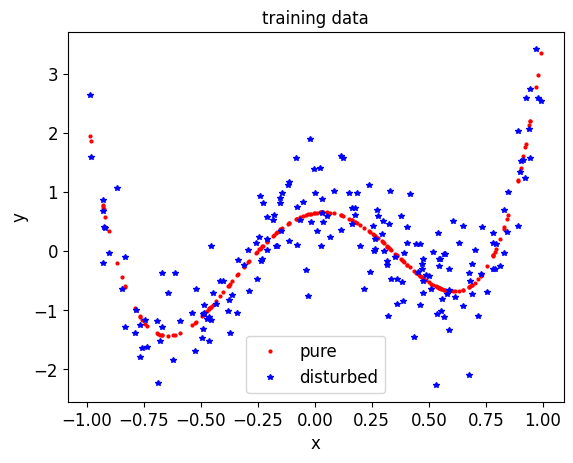

In [5]:
p_x = 1 # input dimension
support = 1.0 # absolute value of the support (the input data will be drawn symmetrically around zero)
n_train = 200 # amount of training data
sigma_y = 10 # noise in output space (standard deviation of normal distribution)
func = func1 # chosen function

# set training parameters
lb = 1 / n_train # regularization parameter
lr = 1 / n_train # initial learning rate
n_ensemble = 10 # number of ensemble members to be independently trained

# initialize uniform weighting of the mixture distributions
alphas0 = torch.zeros(n_ensemble) + 1 / n_ensemble

# generate data
set_seeds(20)
device, tr_loader, train_zeta, train_eta, x_train, y_train, test_zeta, test_eta, x_test, y_test, val_zeta, val_eta, x_val, y_val, sigma_y = f.prepare_datasets(support, n_train, n_val, n_test, p_x, sigma_x, sigma_y, func, mbs, markersz, do_normalize, do_plot)

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


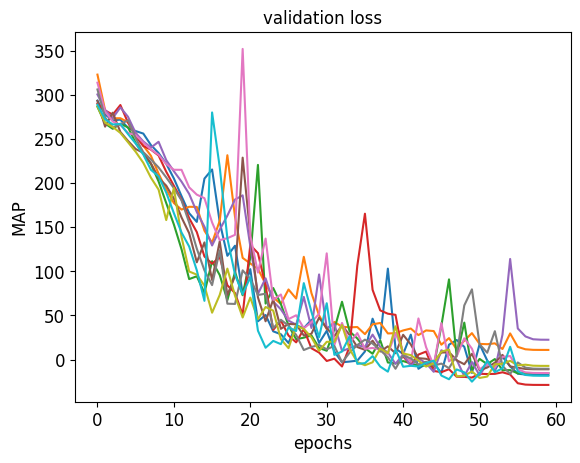

In [6]:
# training
set_seeds(20)
nets_de, f_best = f.run_DE(n_ensemble, device, p_x, p_y, anz_n, lr, lb, gradDecay, sqGradDecay, eps, epochs_last, lrDF, epochs, tr_loader, x_val, y_val.squeeze(), markersz, do_homosc, do_plot)

# analytically calculate weight variances gamma
gammas = f.ensemble_gammas(nets_de, x_train, lb)

coverage probability (epistemic) DE: tensor(0.6280)
coverage probability (epistemic) extended DE: tensor(1.)
rmse: tensor(0.1742)


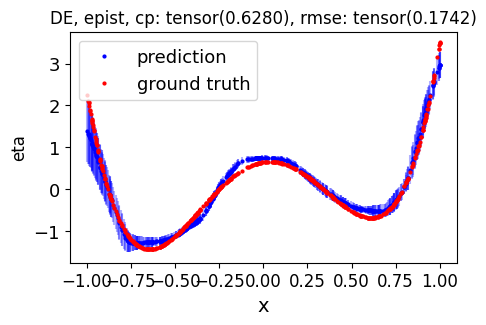

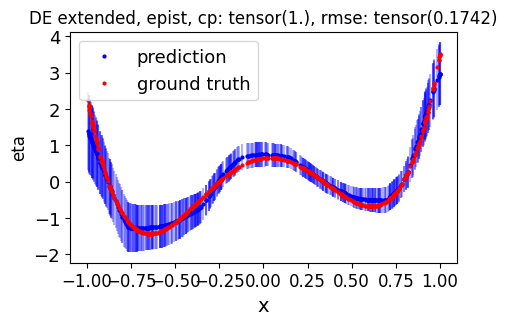

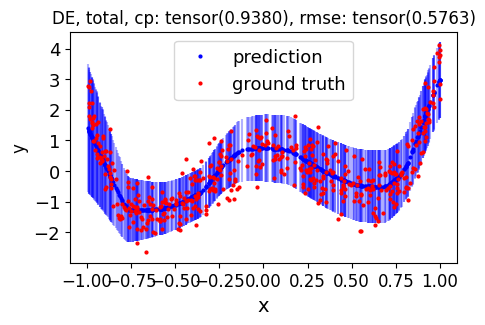

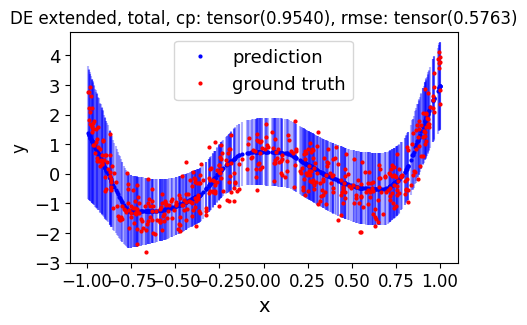

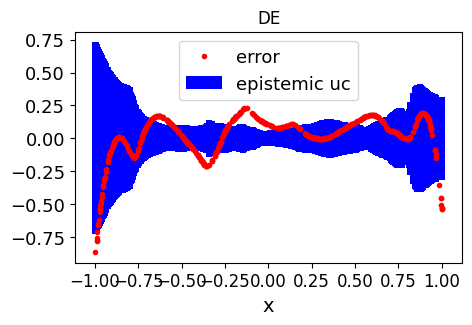

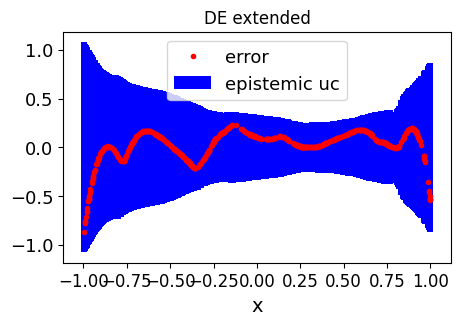

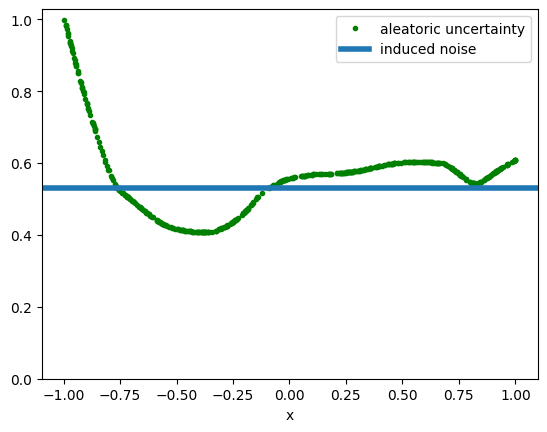

In [7]:
# results
x, y = x_val, val_eta
pred_mu, var_aleat, var_epist = f.ensemble_prediction(nets_de, x, alphas0)
var_epist_add = f.epist_additional(nets_de, x, gammas, alphas0)
print("coverage probability (epistemic) DE: " + str(f.coverage_probability(y, pred_mu, 1.96 * var_epist.sqrt())))
print("coverage probability (epistemic) extended DE: " + str(f.coverage_probability(y, pred_mu, 1.96 * (var_epist + var_epist_add).sqrt())))
print("rmse: " + str(((y - pred_mu)**2).mean().sqrt()))

# plot uncertainties
do_uc = "epist"
f.plot_uncertainties(var_aleat, var_epist, x[:,0], y, pred_mu, "DE", "eta", do_uc, markersz, support)
f.plot_uncertainties(var_aleat, (var_epist + var_epist_add), x[:,0], y, pred_mu, "DE extended", "eta", do_uc, markersz, support)
do_uc = "total" #"aleat"
f.plot_uncertainties(var_aleat, var_epist, x[:,0], y_val, pred_mu, "DE", "y", do_uc, markersz, support)
f.plot_uncertainties(var_aleat, (var_epist + var_epist_add), x[:,0], y_val, pred_mu, "DE extended", "y", do_uc, markersz, support)

f.plot_error_uc_bars(x, pred_mu - y, var_epist, "epistemic uc", "DE")
f.plot_error_uc_bars(x, pred_mu - y, (var_epist + var_epist_add), "epistemic uc", "DE extended")

f.plot_sigmas(x.cpu()[:,0], sigma_y, var_aleat.sqrt(), markersz)

## Algorithm 2:
Sample from the (extended) posterior predictive distribution $\pi(y |x,D)$

1. sample $l$th network uniformly from $l\in\{1, \ldots,L\}$
2. sample network weights $\theta^{(l)}$ from $N(\widehat{\theta}^{(l)},\gamma_l I)$
3. evaluate $\eta_{\theta^{(l)}}(x)$ and $\sigma_{\hat{\theta}^{(l)}}^2(x)$
4. sample from $N \left( \eta_{\theta^{(l)}}(x), \sigma_{\hat{\theta}^{(l)}}^2(x) I \right)$

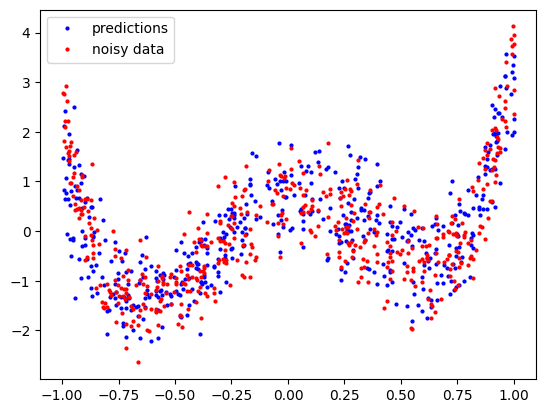

In [8]:
repetition = 1
# steps 1.-3.
y_hat, var_aleat_hat = f.sample_ensemble_posterior_eta(x, nets_de, gammas, alphas0, device, repetition)
# sample a new prediction
y_samples = y_hat + var_aleat_hat.sqrt() * torch.tensor(np.random.normal(size = y_hat.shape))

# plot prediction vs noisy data
plt.plot(x.cpu(), y_samples.T, 'b.', markersize = markersz, label = "predictions")
plt.plot(x.cpu(), y_val.cpu(), 'r.', markersize = markersz, label = "noisy data")
plt.legend()
plt.show()

## Results for a growing number of ensemble members

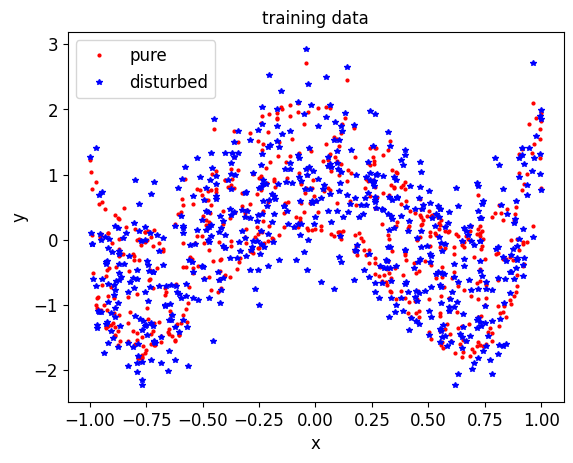

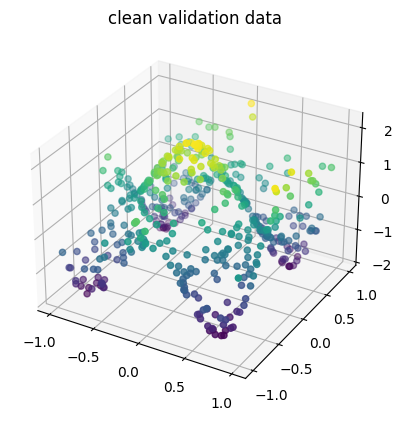

--------- train DE ---------
train 1 from 120
train 2 from 120
train 3 from 120
train 4 from 120
train 5 from 120
train 6 from 120
train 7 from 120
train 8 from 120
train 9 from 120
train 10 from 120
train 11 from 120
train 12 from 120
train 13 from 120
train 14 from 120
train 15 from 120
train 16 from 120
train 17 from 120
train 18 from 120
train 19 from 120
train 20 from 120
train 21 from 120
train 22 from 120
train 23 from 120
train 24 from 120
train 25 from 120
train 26 from 120
train 27 from 120
train 28 from 120
train 29 from 120
train 30 from 120
train 31 from 120
train 32 from 120
train 33 from 120
train 34 from 120
train 35 from 120
train 36 from 120
train 37 from 120
train 38 from 120
train 39 from 120
train 40 from 120
train 41 from 120
train 42 from 120
train 43 from 120
train 44 from 120
train 45 from 120
train 46 from 120
train 47 from 120
train 48 from 120
train 49 from 120
train 50 from 120
train 51 from 120
train 52 from 120
train 53 from 120
train 54 from 120
train 55

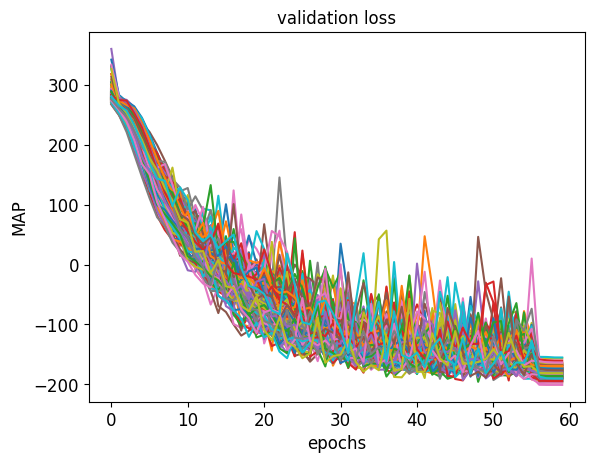

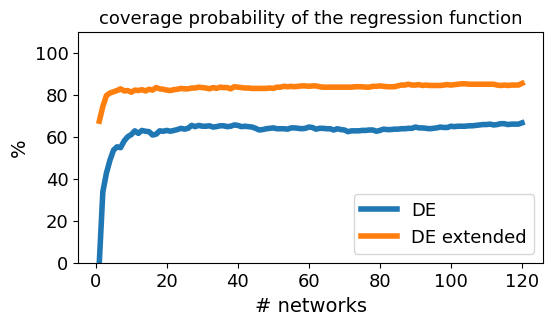

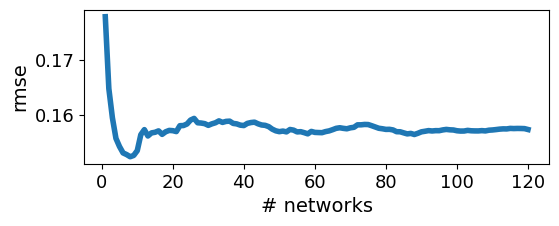

In [9]:
# set data parameters
p_x = 2
n_train = 600
sigma_y = 0.2
func = func2 

# set training parameters
lb = 1 / n_train
lr = 1 / n_train
n_ensemble = 120

# generate data
set_seeds(20)
device, tr_loader, train_zeta, train_eta, x_train, y_train, test_zeta, test_eta, x_test, y_test, val_zeta, val_eta, x_val, y_val, sigma_y = f.prepare_datasets(support, n_train, n_val, n_test, p_x, sigma_x, sigma_y, func, mbs, markersz, do_normalize, do_plot)

# train network
set_seeds(20)
nets_de, f_best = f.run_DE(n_ensemble, device,p_x, p_y, anz_n, lr, lb, gradDecay, sqGradDecay, eps, epochs_last, lrDF, epochs, tr_loader, x_val, y_val.squeeze(), markersz, do_homosc, do_plot)

x, y = x_val, val_eta
n = torch.tensor(range(1, n_ensemble + 1))
cp = torch.zeros(n_ensemble)
cp_extend = torch.zeros(n_ensemble)
rmse = torch.zeros(n_ensemble)

for i in range(n_ensemble):
    de = nets_de[:(i+1)]
    alphas = torch.zeros(i + 1) + 1 / (i + 1)
    gammas = f.ensemble_gammas(de, x_train, lb)
    pred_mu, var_aleat, var_epist = f.ensemble_prediction(de, x, alphas)
    var_epist_add = f.epist_additional(de, x, gammas, alphas)
    cp[i] = f.coverage_probability(y, pred_mu, 1.96 * var_epist.sqrt())
    cp_extend[i] = f.coverage_probability(y, pred_mu, 1.96 * (var_epist + var_epist_add).sqrt())
    rmse[i] = ((y - pred_mu)**2).mean().sqrt()
    
f.plot_cp(n, cp, cp_extend, rmse, "# networks", markersz)

## Results for a growing number of training data

0:


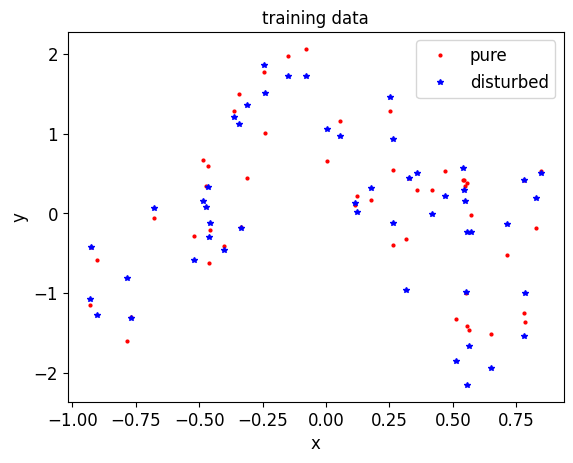

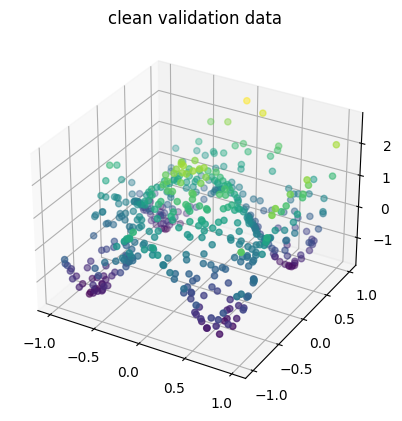

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


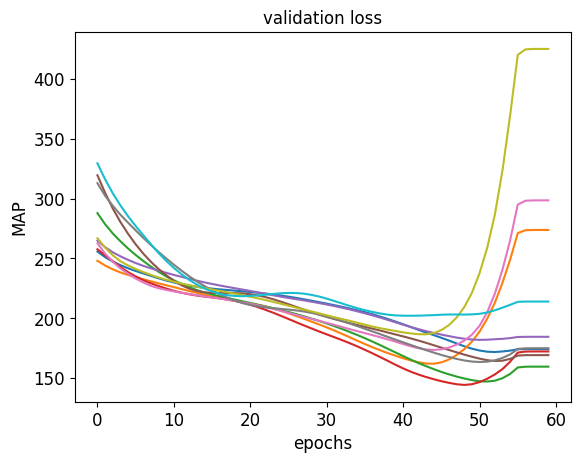

1:


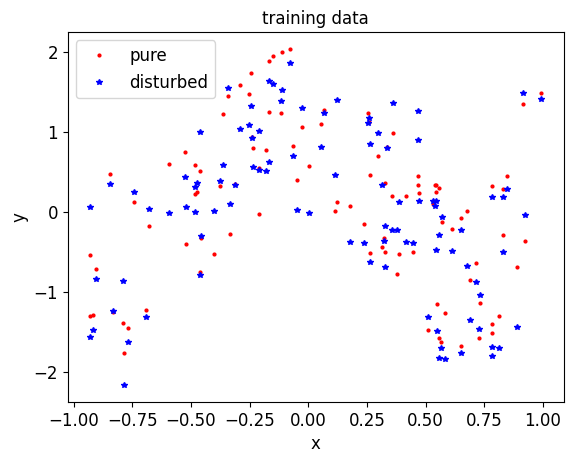

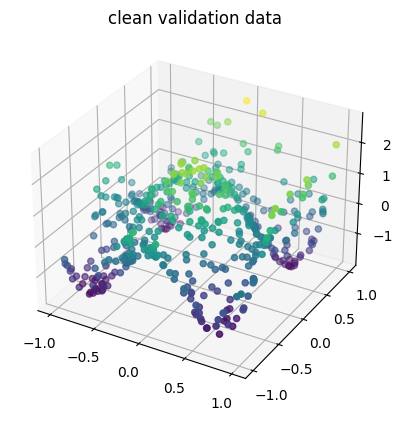

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


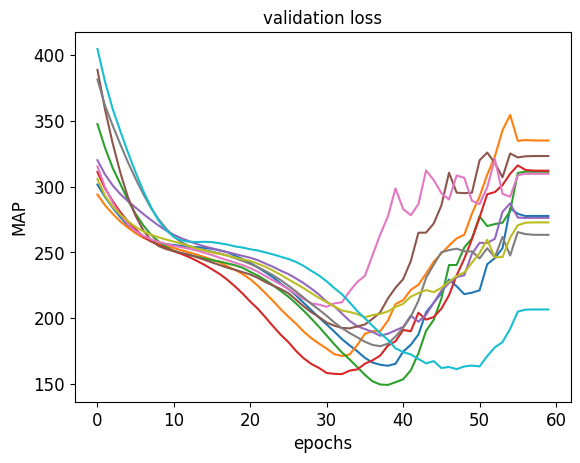

2:


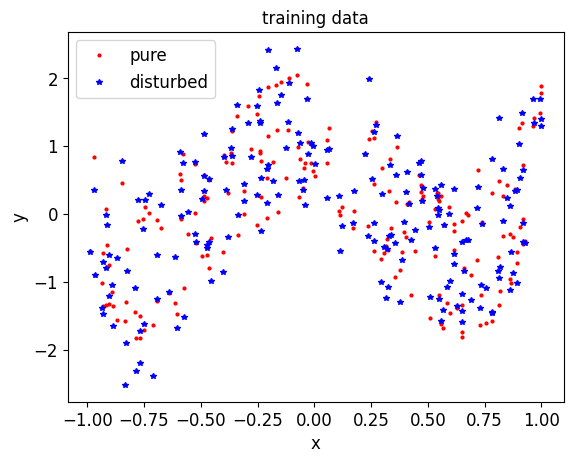

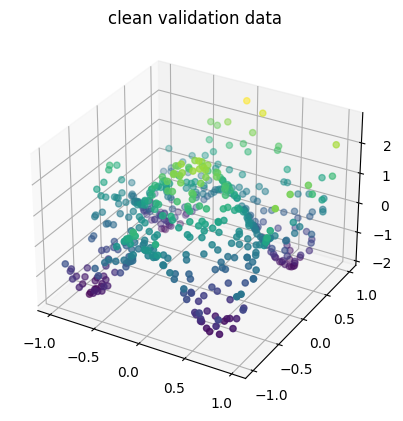

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


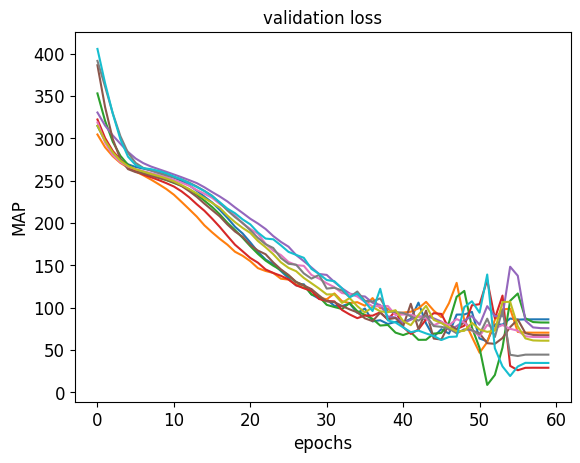

3:


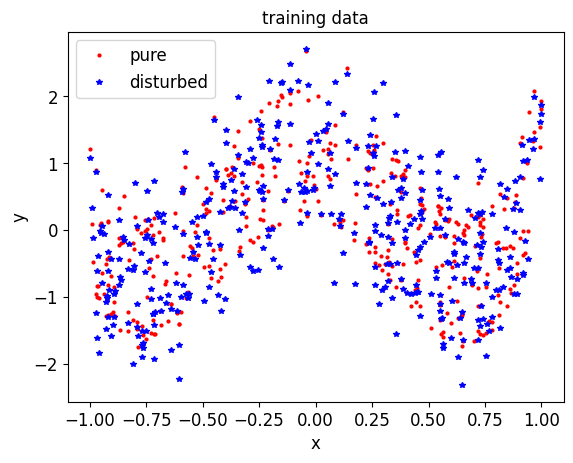

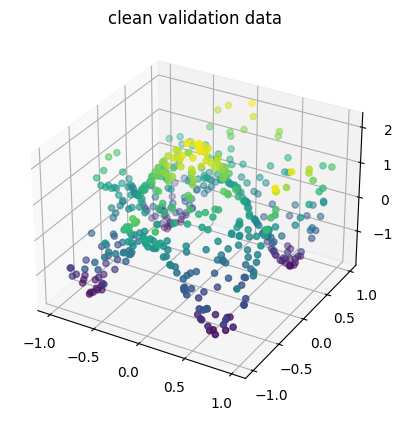

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


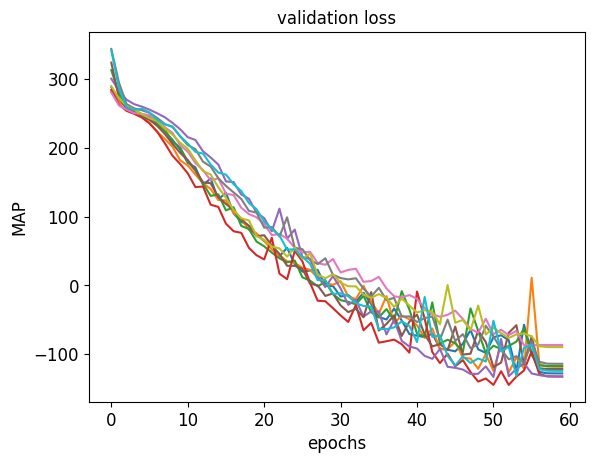

4:


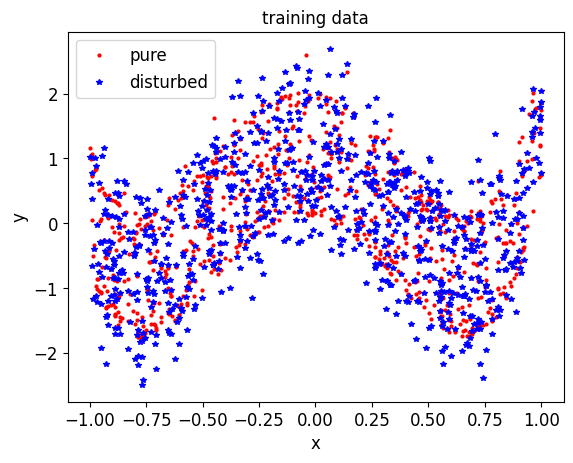

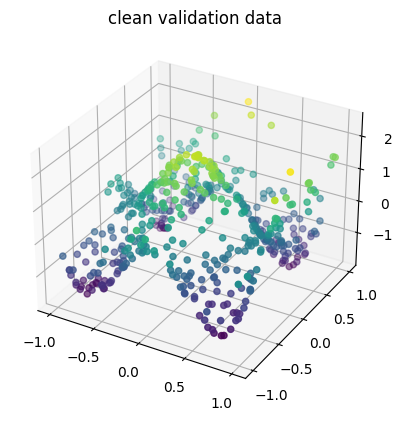

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


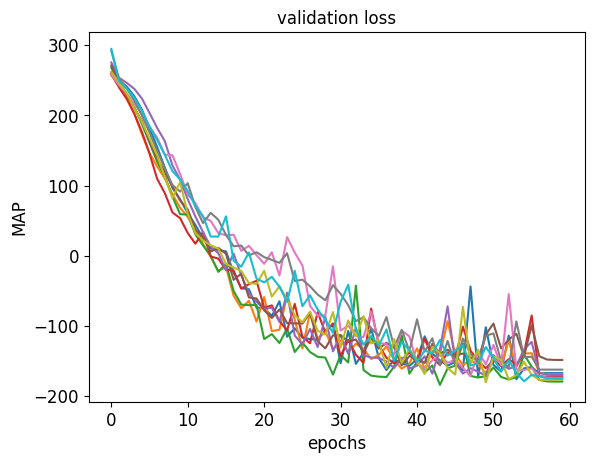

5:


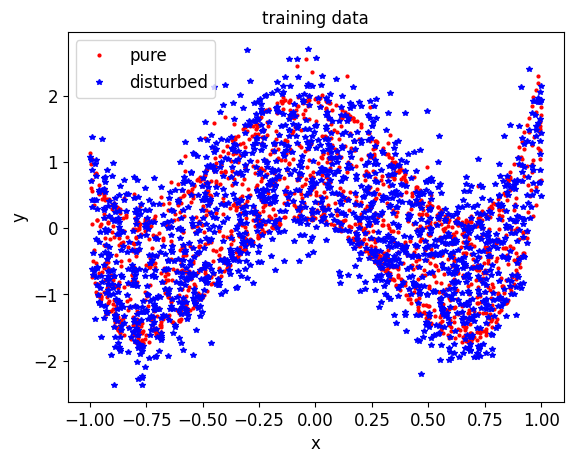

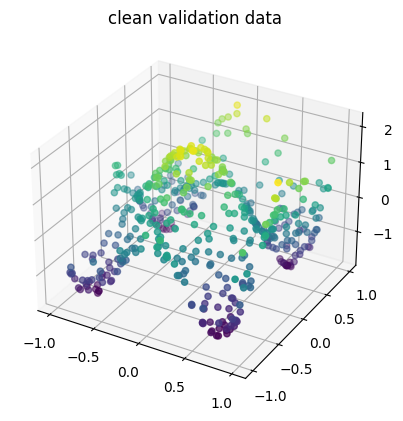

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


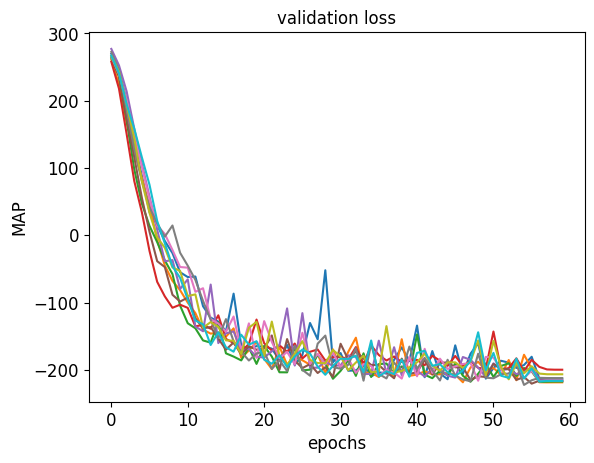

6:


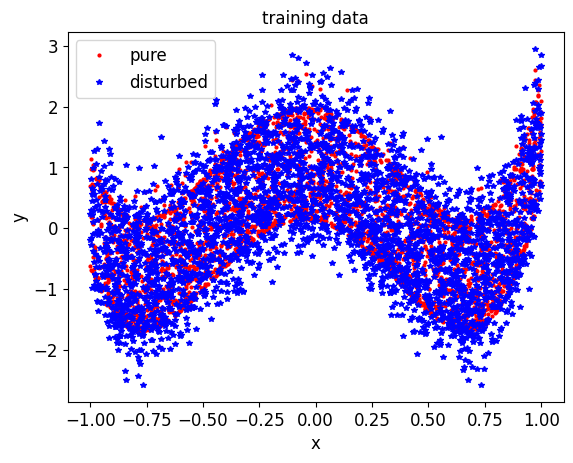

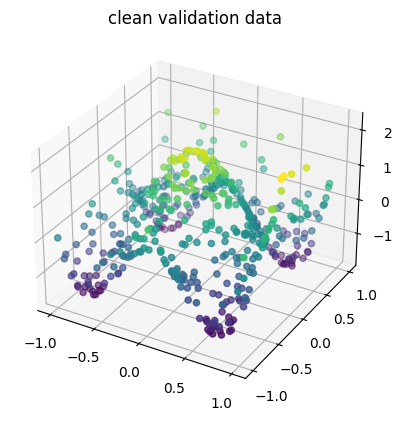

--------- train DE ---------
train 1 from 10
train 2 from 10
train 3 from 10
train 4 from 10
train 5 from 10
train 6 from 10
train 7 from 10
train 8 from 10
train 9 from 10
train 10 from 10


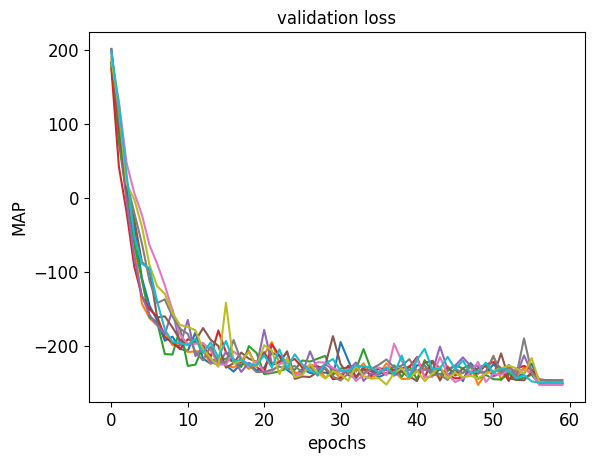

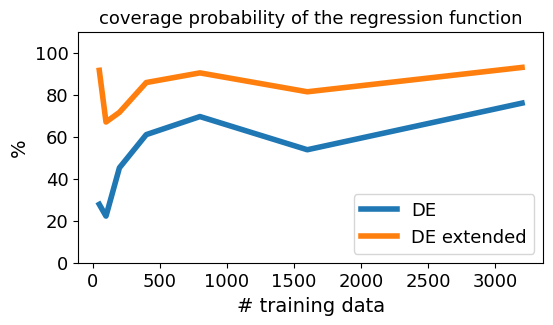

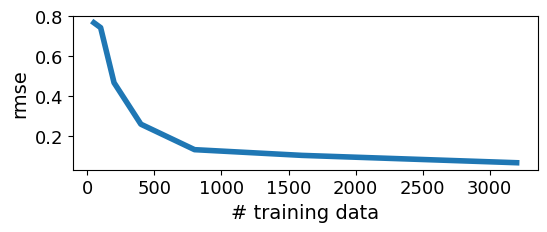

In [10]:
# set data parameters
p_x = 2
sigma_y = 0.2
func = func2 

# set training parameters
lr = 0.001 
n_ensemble = 10
alphas0 = torch.zeros(n_ensemble) + 1/n_ensemble

n_steps = 7

n = torch.zeros(n_steps)
cp = torch.zeros(n_steps)
cp_extend = torch.zeros(n_steps)
rmse = torch.zeros(n_steps)

for i in range(n_steps):
    print(str(i) + ":")
    n_train = 50 * (2**i)
    lb = 1 / n_train
    n[i] = n_train

    set_seeds(20)
    device, tr_loader, train_zeta, train_eta, x_train, y_train, test_zeta, test_eta, x_test, y_test, val_zeta, val_eta, x_val, y_val, sigma_y_scaled = f.prepare_datasets(support, n_train, n_val, n_test, p_x, sigma_x, sigma_y, func, mbs, markersz, do_normalize, do_plot)
    
    x, y = x_val, val_eta
    set_seeds(20)
    nets_de, f_best = f.run_DE(n_ensemble, device, p_x, p_y, anz_n, lr, lb, gradDecay, sqGradDecay, eps, epochs_last, lrDF, epochs, tr_loader, x_val, y_val.squeeze(), markersz, do_homosc, do_plot)
    gammas = f.ensemble_gammas(nets_de, x_train, lb)
    pred_mu, var_aleat, var_epist = f.ensemble_prediction(nets_de, x, alphas0)
    var_epist_add = f.epist_additional(nets_de, x, gammas, alphas0)
    cp[i] = f.coverage_probability(y, pred_mu, 1.96 * var_epist.sqrt())
    cp_extend[i] = f.coverage_probability(y, pred_mu, 1.96 * (var_epist + var_epist_add).sqrt())
    rmse[i] = ((y - pred_mu)**2).mean().sqrt()
    
f.plot_cp(n, cp, cp_extend, rmse, "# training data", markersz)